n this notebook you'll familiarize yourself with how to read a 2D dicom image (specifically a chest X-ray) Data come from the "The Society for Imaging Informatics in Medicine (SIIM) and the American College of Radiology (ACR)" pneuomothorax imaging challenge https://siim.org/page/pneumothorax_challenge

In [6]:
import pandas as pd
from pydicom import dcmread 
import matplotlib.pyplot as plt
import numpy as np
import glob 
import os
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize


import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")




### Overview of DICOM Image Processing and Visualization

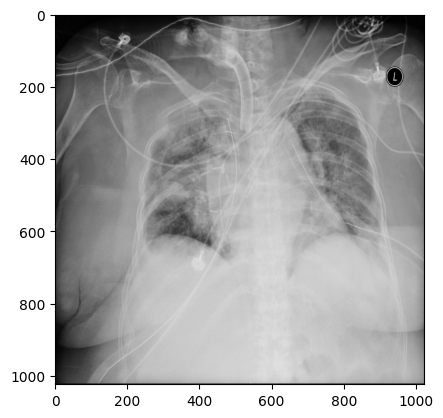

(1024, 1024, 3)


In [7]:

ds = dcmread("dicom_files/1.2.276.0.7230010.3.1.4.8323329.300.1517875162.258081.dcm")
plt.imshow(ds.pixel_array, cmap=plt.cm.gray) # Display the Image
plt.show()
img = ds.pixel_array
img = np.stack([img, img, img], axis=-1) # convert to RGB 
img = img/255.
print(img.shape)

The image is stacked into 3 channels to convert it into RGB format. The values are normalized by dividing by 255.

In [8]:
ds

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 200
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.300.1517875162.258081
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.300.1517875162.258081
(0008,0020) Study Date                          DA: '19010101'
(0008,0030) Study Time                      

In [9]:
ab = ds.pixel_array
ab

array([[  0,   0,   2, ...,   2,   2,   2],
       [  0,   1,   2, ...,   4,   4,   4],
       [  0,   2,   3, ...,   4,   3,   3],
       ...,
       [  0,   5,  21, ..., 137, 137, 140],
       [  2,   6,  17, ..., 112, 112, 112],
       [  0,   0,   3, ...,   0,   0,   0]],
      shape=(1024, 1024), dtype=uint8)

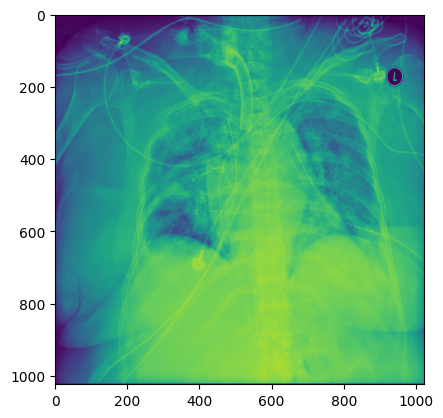

In [10]:
plt.imshow (ab)

This shows a cropped or adjusted version of the image with specific brightness (vmin/vmax) settings, and removes axis labels for a cleaner display.


(np.float64(-0.5), np.float64(1023.5), np.float64(1023.5), np.float64(-0.5))

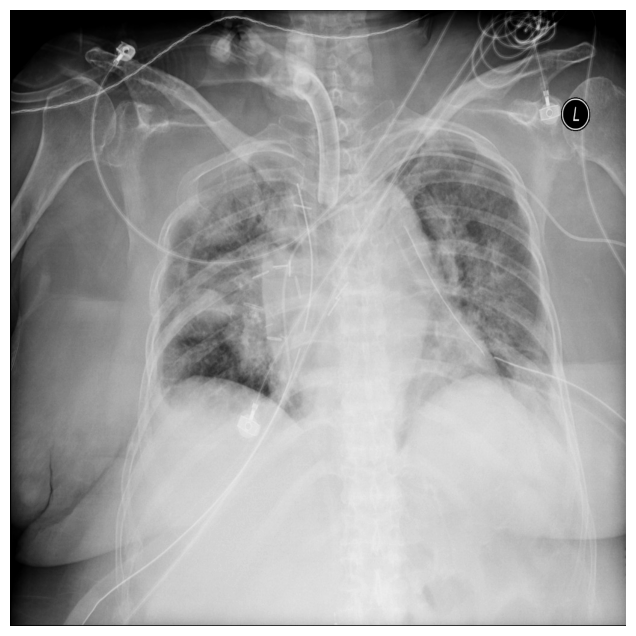

In [11]:
plt.figure(figsize=(8,8))
plt.imshow(ab[:,:],cmap='gray',vmin=10,vmax=240)
plt.axis('off')

In [12]:
dicomList = glob.glob('dicom_files/*.dcm')

The code collects all .dcm files from the dicom_files directory.

In [13]:
len(dicomList)

800

In [14]:
nAnalisi = len(dicomList)
immDimV = np.zeros((2,nAnalisi))
pixSpV = np.zeros((2,nAnalisi))
sexV = np.zeros((1,nAnalisi))
ageV = np.zeros((1,nAnalisi))

Arrays are created to store image dimensions, pixel spacing, sex, and age of patients.


In [15]:
for idx,fName  in enumerate(dicomList[:nAnalisi]):
    dcmFL = dcmread(fName)
    immDimV[0,idx] = dcmFL.Rows
    immDimV[1,idx] = dcmFL.Columns
    pixSpV[:,idx] = dcmFL.PixelSpacing
    if dcmFL.PatientSex == 'F':
        sexV[0,idx]=1
    elif dcmFL.PatientSex == 'M':
        sexV[0,idx]=0
    else:
        sexV[0,idx]=-1
    ageV[0,idx] = int(dcmFL.PatientAge)

In [16]:
myDB = pd.read_csv('train-rle.csv')

In [17]:
myDB

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1
2,1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 ...
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24 999 25 999 25 999 26 997 27 997 27 996 28 996 28 996 29 994 30 994 30 994 30 993 31 993 32 992 32 9...
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 12 1010 12 1011 12 1010 13 1009 14 1008 15 1008 15 1007 16 1007 16 1006 17 1006 17 1005 17 1005 18 10...
...,...,...
11577,1.2.276.0.7230010.3.1.4.8323329.4461.1517875182.971843,592067 6 1016 10 1012 14 1007 18 1004 20 1003 22 1000 24 999 25 998 26 996 27 996 28 995 28 994 29 994 30 993 30 992 31 992 31 992 32 992 31 992 31 992 31 992 31 991 32 991 32 991 32 992 31 992 3...
11578,1.2.276.0.7230010.3.1.4.8323329.4461.1517875182.971843,610576 3 1001 38 981 53 966 63 956 73 947 87 932 97 922 107 912 117 902 127 893 135 888 146 877 152 873 156 868 161 864 165 861 167 859 167 859 168 858 170 857 169 857 170 856 169 857 168 859 167...
11579,1.2.276.0.7230010.3.1.4.8323329.32730.1517875162.25023,-1
11580,1.2.276.0.7230010.3.1.4.8323329.13252.1517875244.359912,-1


In [18]:
myDB['Healthy'] = np.zeros((len(myDB)),dtype=bool)
myDB['Age'] = np.zeros((len(myDB)),dtype=np.int32)
myDB['PneumothArea'] = np.zeros((len(myDB)),dtype=np.float32)
myDB['Sex'] = 'N/A'
myDB['HasFile'] = False

In [19]:
myDB

,ImageId,EncodedPixels,Healthy,Age,PneumothArea,Sex,HasFile
0,1.2.276.0.7230010.3.1.4.8323329.5597.1517875188.959090,-1,False,0,0.0,N/A,False
1,1.2.276.0.7230010.3.1.4.8323329.12515.1517875239.501137,-1,False,0,0.0,N/A,False
2,1.2.276.0.7230010.3.1.4.8323329.4904.1517875185.355709,175349 7 1013 12 1009 17 1005 19 1003 20 1002 22 1001 22 1000 23 1000 23 1000 23 999 24 999 23 1000 23 999 23 1000 22 1001 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 21 1001 22 1001 21 1002 ...,False,0,0.0,N/A,False
3,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,407576 2 1021 7 1015 10 1013 12 1011 14 1008 17 1006 19 1005 20 1003 21 1003 22 1001 23 1001 24 999 25 999 25 999 26 997 27 997 27 996 28 996 28 996 29 994 30 994 30 994 30 993 31 993 32 992 32 9...,False,0,0.0,N/A,False
4,1.2.276.0.7230010.3.1.4.8323329.32579.1517875161.299312,252069 1 1021 3 1020 4 1018 5 1018 6 1016 7 1015 8 1014 9 1014 9 1013 10 1013 10 1012 11 1011 12 1010 12 1011 12 1010 13 1009 14 1008 15 1008 15 1007 16 1007 16 1006 17 1006 17 1005 17 1005 18 10...,False,0,0.0,N/A,False
...,...,...,...,...,...,...,...
11577,1.2.276.0.7230010.3.1.4.8323329.4461.1517875182.971843,592067 6 1016 10 1012 14 1007 18 1004 20 1003 22 1000 24 999 25 998 26 996 27 996 28 995 28 994 29 994 30 993 30 992 31 992 31 992 32 992 31 992 31 992 31 992 31 991 32 991 32 991 32 992 31 992 3...,False,0,0.0,N/A,False
11578,1.2.276.0.7230010.3.1.4.8323329.4461.1517875182.971843,610576 3 1001 38 981 53 966 63 956 73 947 87 932 97 922 107 912 117 902 127 893 135 888 146 877 152 873 156 868 161 864 165 861 167 859 167 859 168 858 170 857 169 857 170 856 169 857 168 859 167...,False,0,0.0,N/A,False
11579,1.2.276.0.7230010.3.1.4.8323329.32730.1517875162.25023,-1,False,0,0.0,N/A,False
11580,1.2.276.0.7230010.3.1.4.8323329.13252.1517875244.359912,-1,False,0,0.0,N/A,False


In [20]:
for rowIdx,pat in myDB.iterrows():
    fName = os.path.join ('dicom_files',pat['ImageId'] + '.dcm')
    if not os.path.isfile(fName):
        continue
    dcmHead = dcmread(fName)
    myDB.loc[rowIdx,['Sex']]=dcmHead.PatientSex
    myDB.loc[rowIdx,['Age']]=int(dcmHead.PatientAge)
    myDB.loc[rowIdx,['HasFile']]=True
    if '-1' in pat[1]:
        myDB.loc[rowIdx,['Healthy']]=True
    else:
        rleList = np.array([int(s) for s in pat[1].split() ])
        nPix = rleList[1::2]
        myDB.loc[rowIdx,['PneumothArea']]=np.sum(nPix)*np.prod(dcmHead.PixelSpacing)

### Merging with External Dataset
- Title: Merging DICOM Metadata with External Data
Objective: Combine DICOM file information with additional metadata stored in train-rle.csv.
<br>
External file train-rle.csv is read into a pandas DataFrame.
New columns (Healthy, Age, Sex, etc.) are initialized.
Matching DICOM Files with CSV:
<br>

For each record in the CSV, the code checks if the corresponding DICOM file exists.
Patient sex and age are updated in the DataFrame from the DICOM metadata.
<br>

- Healthy Status:

The Healthy status is updated based on the presence of a specific value ('-1'), and pneumothorax areas are calculated using RLE encoding.


In [21]:
myDB['HasFile'].value_counts()

HasFile
False    10714
True       868
Name: count, dtype: int64

In [22]:
filtered_myDB=myDB[myDB['HasFile']]

In [23]:
filtered_myDB

,ImageId,EncodedPixels,Healthy,Age,PneumothArea,Sex,HasFile
19,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,218560 13 16 1 987 41 979 49 970 64 956 74 949 76 947 77 945 80 942 83 938 87 927 98 920 104 900 125 896 129 891 134 884 141 873 164 854 170 845 179 837 187 830 195 826 198 824 200 822 202 820 20...,False,51,592.018999,M,True
20,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,184910 8 1013 13 1009 15 1007 17 1006 17 1004 19 1003 21 1002 21 1001 23 1000 23 999 24 999 23 999 23 1000 23 999 23 998 25 998 25 998 26 998 25 998 24 999 24 999 24 999 24 999 24 1000 23 1000 23...,False,51,65.579943,M,True
52,1.2.276.0.7230010.3.1.4.8323329.335.1517875162.443624,-1,True,64,0.000000,F,True
54,1.2.276.0.7230010.3.1.4.8323329.368.1517875162.584967,205015 2 1021 3 1019 5 1017 6 1016 8 1015 8 1014 9 1014 9 1014 8 1015 8 1015 8 1015 9 1014 9 1014 9 1014 9 1014 9 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1...,False,48,154.165011,F,True
55,1.2.276.0.7230010.3.1.4.8323329.368.1517875162.584967,182874 12 1008 21 1001 24 998 27 996 29 993 32 991 33 990 34 989 35 988 36 987 38 986 38 985 39 985 39 984 40 984 41 982 42 982 42 982 42 981 43 981 43 980 44 980 44 980 44 979 45 979 46 978 46 9...,False,48,57.032261,F,True
...,...,...,...,...,...,...,...
11522,1.2.276.0.7230010.3.1.4.8323329.3998.1517875180.567789,-1,True,73,0.000000,F,True
11528,1.2.276.0.7230010.3.1.4.8323329.3650.1517875178.829405,-1,True,3,0.000000,F,True
11541,1.2.276.0.7230010.3.1.4.8323329.463.1517875163.62182,-1,True,67,0.000000,M,True
11564,1.2.276.0.7230010.3.1.4.8323329.3742.1517875179.241502,-1,True,58,0.000000,M,True


In [24]:
dicom_folder = "dicom_files"
filtered_myDB["dicom_path"] = filtered_myDB["ImageId"].apply(lambda x: os.path.join(dicom_folder, f"{x}.dcm"))


In [25]:
filtered_myDB

,ImageId,EncodedPixels,Healthy,Age,PneumothArea,Sex,HasFile,dicom_path
19,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,218560 13 16 1 987 41 979 49 970 64 956 74 949 76 947 77 945 80 942 83 938 87 927 98 920 104 900 125 896 129 891 134 884 141 873 164 854 170 845 179 837 187 830 195 826 198 824 200 822 202 820 20...,False,51,592.018999,M,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360.dcm
20,1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360,184910 8 1013 13 1009 15 1007 17 1006 17 1004 19 1003 21 1002 21 1001 23 1000 23 999 24 999 23 999 23 1000 23 999 23 998 25 998 25 998 26 998 25 998 24 999 24 999 24 999 24 999 24 1000 23 1000 23...,False,51,65.579943,M,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.3604.1517875178.653360.dcm
52,1.2.276.0.7230010.3.1.4.8323329.335.1517875162.443624,-1,True,64,0.000000,F,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.335.1517875162.443624.dcm
54,1.2.276.0.7230010.3.1.4.8323329.368.1517875162.584967,205015 2 1021 3 1019 5 1017 6 1016 8 1015 8 1014 9 1014 9 1014 8 1015 8 1015 8 1015 9 1014 9 1014 9 1014 9 1014 9 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1013 10 1...,False,48,154.165011,F,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.368.1517875162.584967.dcm
55,1.2.276.0.7230010.3.1.4.8323329.368.1517875162.584967,182874 12 1008 21 1001 24 998 27 996 29 993 32 991 33 990 34 989 35 988 36 987 38 986 38 985 39 985 39 984 40 984 41 982 42 982 42 982 42 981 43 981 43 980 44 980 44 980 44 979 45 979 46 978 46 9...,False,48,57.032261,F,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.368.1517875162.584967.dcm
...,...,...,...,...,...,...,...,...
11522,1.2.276.0.7230010.3.1.4.8323329.3998.1517875180.567789,-1,True,73,0.000000,F,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.3998.1517875180.567789.dcm
11528,1.2.276.0.7230010.3.1.4.8323329.3650.1517875178.829405,-1,True,3,0.000000,F,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.3650.1517875178.829405.dcm
11541,1.2.276.0.7230010.3.1.4.8323329.463.1517875163.62182,-1,True,67,0.000000,M,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.463.1517875163.62182.dcm
11564,1.2.276.0.7230010.3.1.4.8323329.3742.1517875179.241502,-1,True,58,0.000000,M,True,dicom_files\1.2.276.0.7230010.3.1.4.8323329.3742.1517875179.241502.dcm


In [26]:
filtered_myDB = filtered_myDB.drop_duplicates(subset='ImageId')


### Feature Extraction with ResNet50
**Title**: Feature Extraction using ResNet50  
**Objective**: Use a pre-trained deep learning model (ResNet50) to extract feature embeddings from DICOM images.

#### Steps:
1. **Loading Pre-trained Model**:
   - The ResNet50 model is loaded without the top classification layer (`include_top=False`), using the `imagenet` weights.

2. **Resizing and Preprocessing**:
   - Images are resized to 224x224 pixels (required input size for ResNet50).
   - Images are converted from grayscale to RGB, and preprocessed for ResNet50 input.

3. **Extracting Embeddings**:
   - The model generates feature vectors (embeddings) for each image.


In [27]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import cv2


# Step 1: Load the pre-trained ResNet50 model (without the top classification layer)
base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Create a new model using ResNet50's output as the feature vector
model = Model(inputs=base_model.input, outputs=base_model.output)

# Function to extract embeddings using ResNet50
def extract_resnet_embedding(dicom_path):
    try:
        # Read the DICOM file
        dicom = dcmread(dicom_path)
        pixel_array = dicom.pixel_array

        # Resize image to 224x224 (required for ResNet50)
        img = cv2.resize(pixel_array, (224, 224))
        img = np.expand_dims(img, axis=-1)  # Add channel dimension (grayscale to RGB)
        img = np.repeat(img, 3, axis=-1)  # Convert grayscale to 3 channels (RGB)

        # Preprocess the image for ResNet50
        img = preprocess_input(img)

        # Extract features (embedding) from ResNet50
        embedding = model.predict(np.expand_dims(img, axis=0))  # Add batch dimension
        return embedding.flatten()  # Flatten the output of the model to a 1D vector
    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")
        return None




### Dataset with Embeddings

#### Operations:
1. **Embedding DataFrame**:
   - The embeddings are stored in a DataFrame with additional columns for patient features (age, sex, etc.).

2. **Missing Embeddings**:
   - Rows without valid embeddings are removed from the DataFrame to ensure the dataset is clean.


In [28]:

# Step 2: Apply the function to extract embeddings for all DICOM files in your dataset
filtered_myDB["resnet_embedding"] = filtered_myDB["dicom_path"].apply(extract_resnet_embedding)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [29]:

# Drop rows with missing embeddings
filtered_myDB = filtered_myDB[filtered_myDB["resnet_embedding"].notnull()]


In [30]:

# Convert embeddings into a DataFrame
embedding_df = pd.DataFrame(filtered_myDB["resnet_embedding"].tolist())


In [31]:

# Add other features (if any) to the embedding dataframe
# Here, we add features such as Age, Sex, etc., into the model
embedding_df["Age"] = filtered_myDB["Age"]
embedding_df["Sex"] = filtered_myDB["Sex"].map({"Male": 0, "Female": 1})  # Assuming 'Sex' is categorical

# Step 3: Define the target variable (e.g., Healthy status)
#y = filtered_myDB["Healthy"].map({"Healthy": 1, "Unhealthy": 0})  # Adjust based on your dataset
y = filtered_myDB["Healthy"].astype(int)



### Machine Learning Model
**Title**: Training a Random Forest Classifier  
**Objective**: Use the extracted embeddings to train a classification model to predict "Healthy" vs. "Unhealthy" status.

#### Steps:
1. **Data Splitting**:
   - The dataset is split into training and test sets using `train_test_split`.

2. **Training the Model**:
   - A Random Forest Classifier is trained on the features (embeddings, age, sex) to predict the target variable `Healthy`.

3. **Model Evaluation**:
   - Accuracy and a classification report are generated to assess the model's performance.


In [32]:
# Step 4: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(embedding_df, y, test_size=0.2, random_state=42)

# Convert all column names to strings
X_train.columns = X_train.columns.astype(str)
X_test.columns = X_test.columns.astype(str)


In [33]:
# Step 5: Train a classifier (e.g., Random Forest) using the embeddings as input
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 6: Make predictions and evaluate the model
y_pred = rf_model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.80625
              precision    recall  f1-score   support

           0       0.67      0.06      0.11        32
           1       0.81      0.99      0.89       128

    accuracy                           0.81       160
   macro avg       0.74      0.53      0.50       160
weighted avg       0.78      0.81      0.74       160




#### Results:
- **Accuracy**: 80.63%
  
- **Classification Report**:

### Conclusion
**Title**: Conclusion and Next Steps

#### Summary:
- The project successfully used DICOM images for medical image analysis.
- Pre-trained deep learning models (ResNet50) were used to extract embeddings, which were then used for classification tasks.

#### Future Work:
- Improve model performance by tuning hyperparameters.
- Explore other machine learning models or architectures for better predictions.
- Incorporate more diverse patient data for enhanced generalization.

### Training an XGBoost Model
**Title**: Training an XGBoost Classifier  
**Objective**: Use the extracted embeddings to train an XGBoost classifier to predict "Healthy" vs. "Unhealthy" status.


In [34]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Train an XGBoost model
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = xgb_model.predict(X_test)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))


Accuracy: 0.7875
              precision    recall  f1-score   support

           0       0.42      0.16      0.23        32
           1       0.82      0.95      0.88       128

    accuracy                           0.79       160
   macro avg       0.62      0.55      0.55       160
weighted avg       0.74      0.79      0.75       160



###  Comparison of Machine Learning Models
**Title**: Comparison of Random Forest and XGBoost Models  
**Objective**: Compare the performance of two machine learning models (Random Forest and XGBoost).

#### Model Performance Comparison:

| Metric                     | Random Forest | XGBoost   |
|----------------------------|---------------|-----------|
| **Accuracy**               | 80.63%        | 78.75%    |
| **Precision (Healthy)**    | 0.81          | 0.82      |
| **Precision (Unhealthy)**  | 0.67          | 0.42      |
| **Recall (Healthy)**       | 0.99          | 0.95      |
| **Recall (Unhealthy)**     | 0.06          | 0.16      |
| **F1-Score (Healthy)**     | 0.89          | 0.88      |
| **F1-Score (Unhealthy)**   | 0.11          | 0.23      |

---

#### Observations:

**Random Forest**:
- Higher overall accuracy (80.63%).
- Better performance in detecting unhealthy cases (low recall in XGBoost for "Unhealthy").
- The model is more balanced in terms of recall across both classes.

**XGBoost**:
- Slightly lower overall accuracy (78.75%).
- Higher precision for the "Healthy" class but poorer precision for the "Unhealthy" class compared to Random Forest.
- The model is better at detecting "Healthy" cases (higher recall), but misses many "Unhealthy" cases.

---

#### Conclusion:
- Both models perform well, but **Random Forest** seems to have a better balance between precision and recall.
- **XGBoost** is more biased towards detecting the "Healthy" class and struggles with identifying the "Unhealthy" class (lower recall and precision).


---
# Part 2

## **Clustering**

### Feature Extraction with Pre-Trained CNN (ResNet50)
**Title**: Feature Extraction with ResNet50  
**Objective**: Use a pre-trained Convolutional Neural Network (CNN) model, such as ResNet50, to extract features from DICOM images.

#### Steps:
1. **Loading the Pre-Trained Model**:
   - A pre-trained ResNet50 model is loaded without the top classification layer (`include_top=False`).
   - The model is used to extract features (without performing classification).

2. **Extracting Features from DICOM Images**:
   - The `extract_features` function reads a DICOM file, resizes the image to 224x224, normalizes it, and then extracts features using the ResNet50 model.

3. **Resizing and Normalizing the Image**:
   - Each image is resized to 224x224 pixels, normalized to a [0, 1] range, and then expanded to include a batch dimension.

4. **Extracting Features**:
   - The features are extracted by passing the image through the ResNet50 model, which returns feature vectors.


In [36]:
# Load a pre-trained CNN (e.g., ResNet50)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224,224,3))

def extract_features(dicom_path):
    try:
        ds = dcmread(dicom_path)
        if 'PixelData' not in ds:
            print(f"File {dicom_path} does not contain pixel data. Skipping.")
            return None
        img = ds.pixel_array
        img = np.stack([img, img, img], axis=-1)
        img = tf.image.resize(img, (224, 224)) # Resize
        img = img / 255.0  # Normalize
        img = np.expand_dims(img, axis=0) # Add batch dimension
        features = base_model.predict(img) # Extract features
        return features.flatten()
    except Exception as e:
        print(f"Error processing {dicom_path}: {e}")
        return None



In [37]:
# Path to your DICOM files folder
dicom_folder = 'dicom_files'

# Create an empty list to store the file paths
dicom_files = []

# Walk through the directory and its subdirectories
for root, _, files in os.walk(dicom_folder):
    for file in files:
        if file.lower().endswith('.dcm'):  # Check for .dcm extension (case-insensitive)
            file_path = os.path.join(root, file)
            dicom_files.append(file_path)

# Now dicom_files is a list of all .dcm file paths in your folder
print(f"Found {len(dicom_files)} DICOM files.")


Found 800 DICOM files.



### Dataset Creation and Clustering
**Title**: Creating a Dataset and Clustering the Features  
**Objective**: Organize the extracted features and apply K-Means clustering to group similar images.

#### Steps:
1. **Loading DICOM Files**:
   - All DICOM files in the specified directory are loaded, and their file paths are stored in a list (`dicom_files`).

2. **Feature Extraction**:
   - Features are extracted for each DICOM file using the `extract_features` function. The results are stored in `features_list` and converted into a NumPy array (`features_array`).

3. **Normalizing Features**:
   - The extracted features are normalized using `sklearn.preprocessing.normalize` to ensure all features are on the same scale.

4. **Clustering with K-Means**:
   - K-Means clustering is applied to the normalized features, with a variable number of clusters (up to 5, or fewer if there are fewer images).

5. **Visualizing Clusters**:
   - The images within each cluster are visualized using `matplotlib`, showing a few representative images from each cluster.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

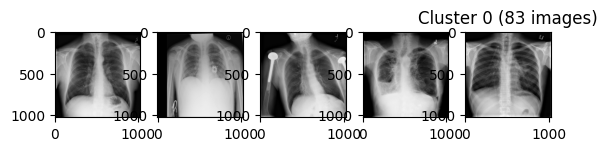

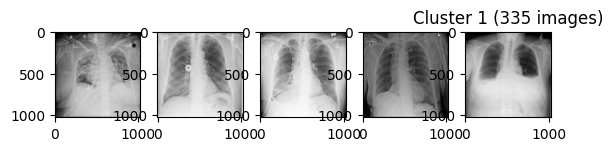

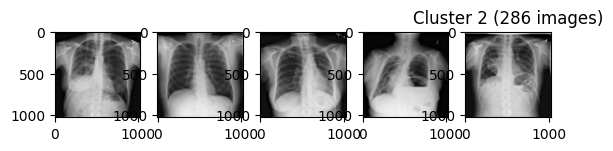

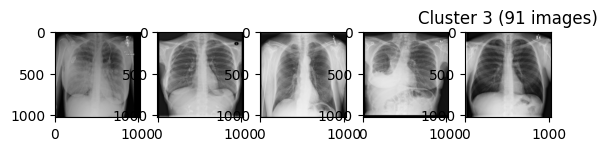

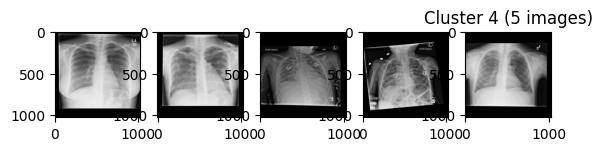

In [38]:
features_list = []
for dicom_file in dicom_files:
    features = extract_features(dicom_file)
    if features is not None:
        features_list.append(features)

features_array = np.array(features_list)
normalized_features = normalize(features_array)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=min(5, len(features_array)), random_state=0)  # Choose the number of clusters
kmeans.fit(normalized_features)
labels = kmeans.labels_

# visualize some images from each cluster
for i in range(min(5, len(np.unique(labels)))):
    cluster_indices = np.where(labels == i)[0]
    plt.figure()
    for j in range(min(5, len(cluster_indices))):  # Show max 5 images per cluster
        index = cluster_indices[j]
        ds = dcmread(dicom_files[index])
        plt.subplot(1, min(5, len(cluster_indices)), j + 1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
    plt.title(f"Cluster {i} ({len(cluster_indices)} images)")
    plt.show()


In [39]:
from collections import Counter

# Count the number of images in each cluster
cluster_counts = Counter(labels)
print("Cluster distribution:")
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} images")


Cluster distribution:
Cluster 1: 335 images
Cluster 2: 286 images
Cluster 0: 83 images
Cluster 4: 5 images
Cluster 3: 91 images



#### Observations:
- The images are grouped into several clusters based on the extracted features.
- Each cluster represents a group of similar images. For example, Cluster 1 has the highest number of images, while Cluster 4 has only 5 images.


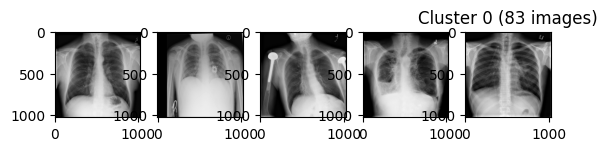

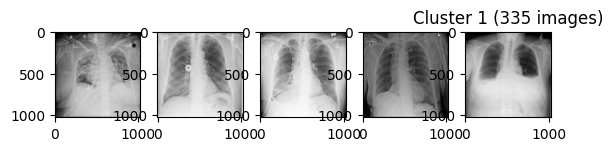

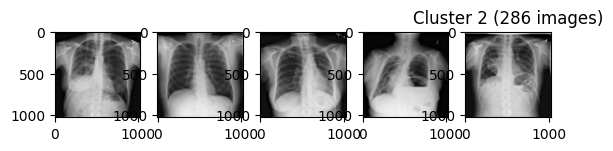

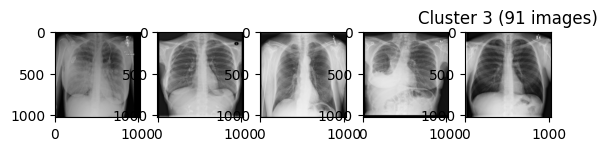

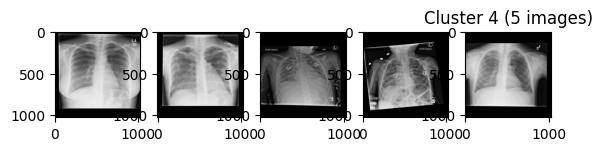

In [40]:
for i in range(min(5, len(np.unique(labels)))):
    cluster_indices = np.where(labels == i)[0]
    plt.figure()
    for j in range(min(5, len(cluster_indices))):  # Show max 5 images per cluster
        index = cluster_indices[j]
        ds = dcmread(dicom_files[index])
        plt.subplot(1, min(5, len(cluster_indices)), j + 1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
    plt.title(f"Cluster {i} ({len(cluster_indices)} images)")
    plt.show()



### Conclusion and Future Work
**Title**: Conclusion and Next Steps

#### Summary:
- A pre-trained ResNet50 model was used to extract features from DICOM images.
- K-Means clustering was applied to group similar images based on the extracted features.
- The images were successfully clustered, and their distribution across clusters was analyzed.

#### Future Work:
- Explore the impact of different clustering techniques (e.g., DBSCAN, Agglomerative Clustering).
- Use the clustered data for further analysis or classification tasks.
- Investigate how feature extraction from different models (e.g., VGG16, InceptionV3) compares to ResNet50.

In [41]:
import pandas as pd

# Load the CSV file
train_rle_path = "train-rle.csv"
train_rle = pd.read_csv(train_rle_path)

# Strip any leading or trailing spaces from the column names
train_rle.columns = train_rle.columns.str.strip()

# Define a function to check pneumothorax status
def has_pneumothorax(EncodedPixels):
    return not (EncodedPixels.strip() == "-1")

# Add a column for pneumothorax status
train_rle['has_pneumothorax'] = train_rle['EncodedPixels'].apply(has_pneumothorax)

# Map imageId to pneumothorax status for quick lookup
image_pneumothorax_map = dict(zip(train_rle['ImageId'], train_rle['has_pneumothorax']))

print(f"Total Images: {len(train_rle)}")
print(f"Pneumothorax Cases: {train_rle['has_pneumothorax'].sum()}")


Total Images: 11582
Pneumothorax Cases: 3286


In [42]:
features_list = []
labels_list = []

for dicom_file in dicom_files:
    # Extract the image ID from the file name
    image_id = os.path.basename(dicom_file).replace('.dcm', '')
    if image_id not in image_pneumothorax_map:
        print(f"Image ID {image_id} not found in train_rle.csv. Skipping.")
        continue

    features = extract_features(dicom_file)
    if features is not None:
        features_list.append(features)
        labels_list.append(image_pneumothorax_map[image_id])

features_array = np.array(features_list)
labels_array = np.array(labels_list)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

Cluster Analysis:
has_pneumothorax  False  True 
cluster                       
0                    58     24
1                   281     68
2                   219     61
3                    64     18
4                     5      0


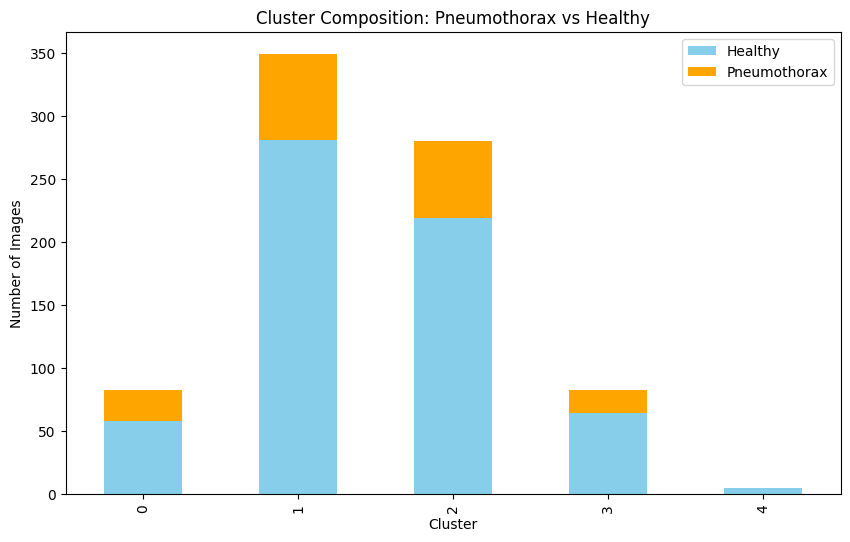

In [43]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=min(5, len(features_array)), random_state=0)
kmeans.fit(normalize(features_array))
cluster_labels = kmeans.labels_

# Analyze cluster composition
from collections import Counter

# Create a DataFrame for better analysis
cluster_df = pd.DataFrame({
    'cluster': cluster_labels,
    'has_pneumothorax': labels_array
})

# Count occurrences in each cluster
cluster_analysis = cluster_df.groupby('cluster')['has_pneumothorax'].value_counts().unstack(fill_value=0)
print("Cluster Analysis:")
print(cluster_analysis)

# Plot cluster composition
cluster_analysis.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange'])
plt.title("Cluster Composition: Pneumothorax vs Healthy")
plt.xlabel("Cluster")
plt.ylabel("Number of Images")
plt.legend(["Healthy", "Pneumothorax"])
plt.show()



## K-Means Clustering**

- **Clustering**: The K-Means algorithm was applied to the extracted features to classify the images into 5 clusters (limited by the number of available images).
- **Normalization**: Feature data was normalized before applying clustering.

---

## Cluster Analysis**

The following cluster composition analysis was performed:

| Cluster ID | Healthy Images | Pneumothorax Images |
|------------|----------------|---------------------|
| 0          | 58             | 24                  |
| 1          | 281            | 68                  |
| 2          | 219            | 61                  |
| 3          | 64             | 18                  |
| 4          | 5              | 0                   |

- **Cluster Composition**: The clusters were examined based on their distribution of healthy vs pneumothorax images.



## **Cluster Visualization**

- **Bar Chart**: The distribution of healthy vs pneumothorax images in each cluster was visualized using a stacked bar chart.


---

## **Representative Images per Cluster**

For each cluster, representative images were displayed to better understand the classification:

- **Pneumothorax images**: Two images with pneumothorax from each cluster were shown.
- **Healthy images**: Two images without pneumothorax from each cluster were displayed.

This allows a visual understanding of how each cluster is composed and aids in the analysis of the model's performance.

---

## **Conclusion**

- **Data Insights**: The dataset contains 11,582 images with a significant proportion of pneumothorax cases (3,286).
- **Cluster Patterns**: Clustering reveals varying levels of pneumothorax distribution across the clusters.
- **Visual Insights**: Representative images provide an intuitive understanding of how the algorithm groups healthy and pneumothorax cases.

The analysis helps in understanding the model's ability to differentiate between healthy and pneumothorax cases and paves the way for further tuning and evaluation.








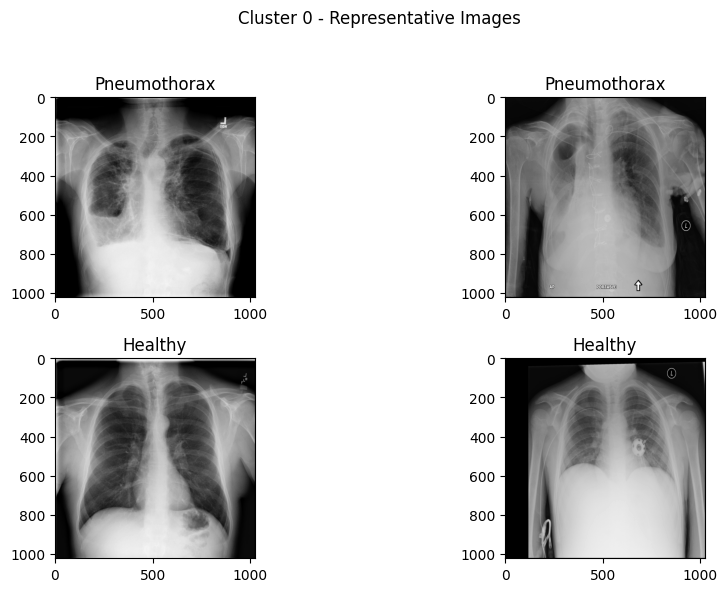

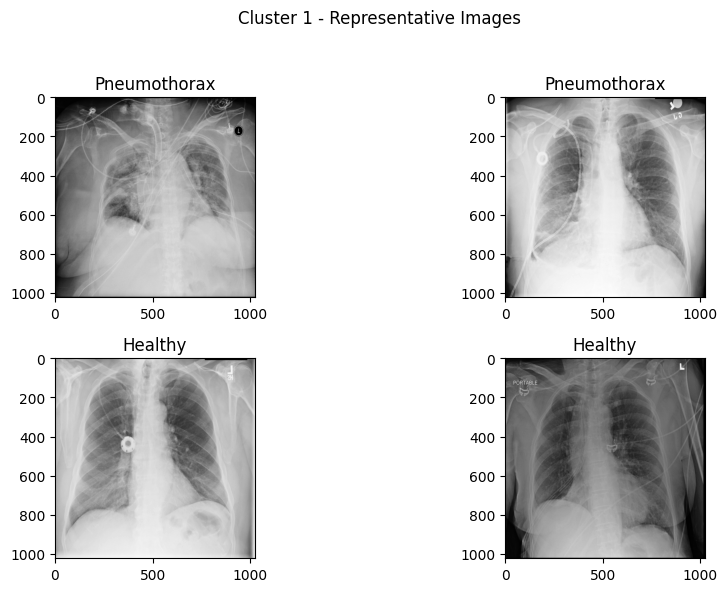

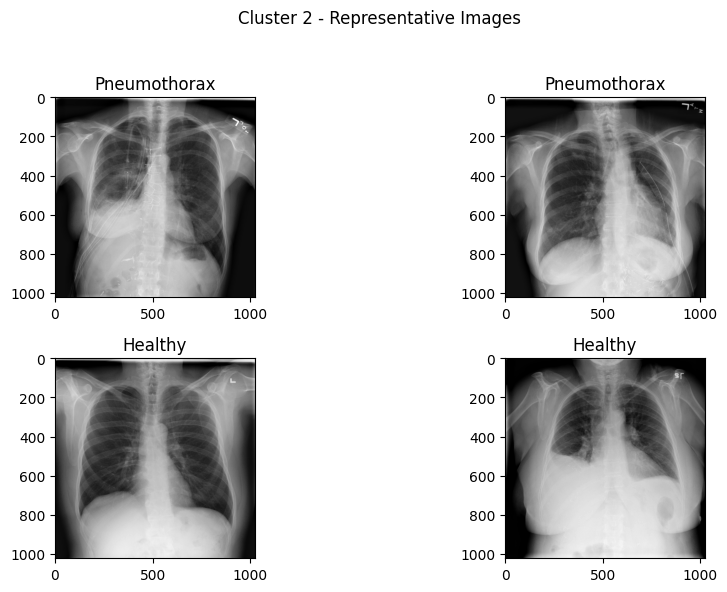

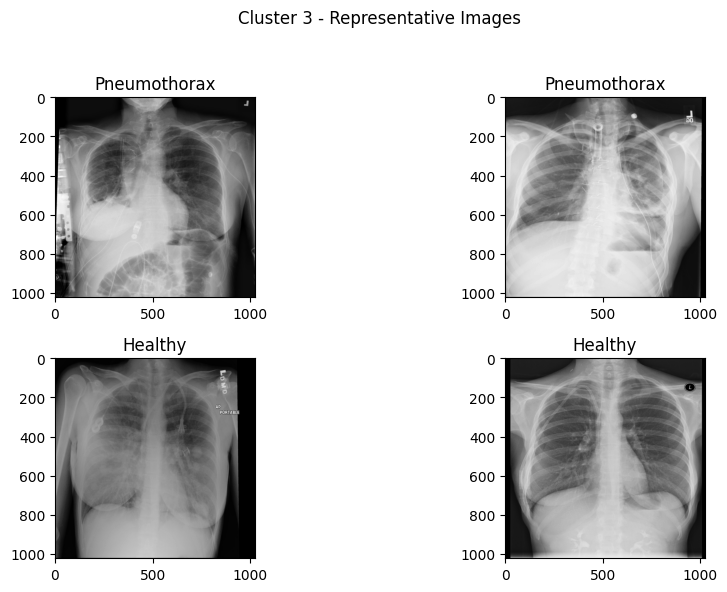

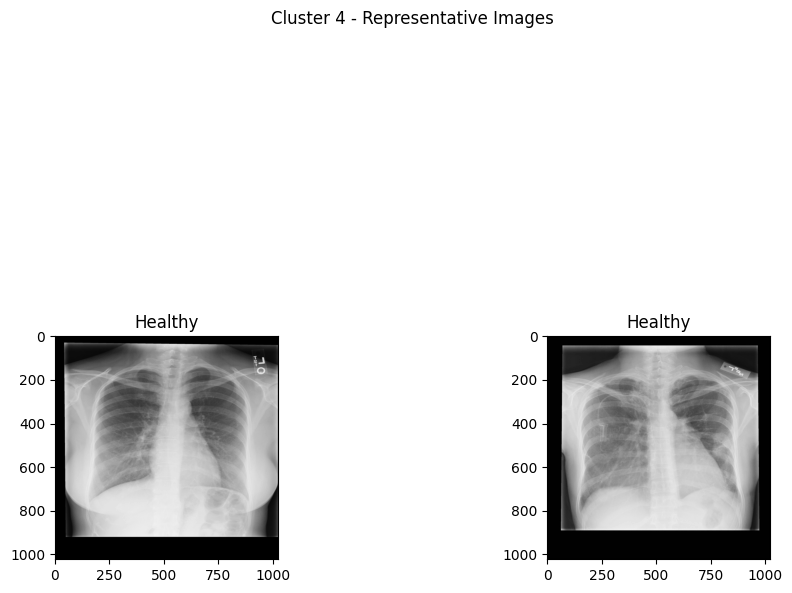

In [44]:
for cluster_id in range(len(cluster_analysis)):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    plt.figure(figsize=(10, 6))
    plt.suptitle(f"Cluster {cluster_id} - Representative Images")
    
    pneumothorax_indices = [i for i in cluster_indices if labels_array[i]]
    healthy_indices = [i for i in cluster_indices if not labels_array[i]]
    
    for j, index in enumerate(pneumothorax_indices[:2]):  # Max 2 pneumothorax images
        ds = dcmread(dicom_files[index])
        plt.subplot(2, 2, j + 1)
        plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
        plt.title("Pneumothorax")
    
    for j, index in enumerate(healthy_indices[:2]):  # Max 2 healthy images
        ds = dcmread(dicom_files[index])
        plt.subplot(2, 2, j + 3)
        plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
        plt.title("Healthy")
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


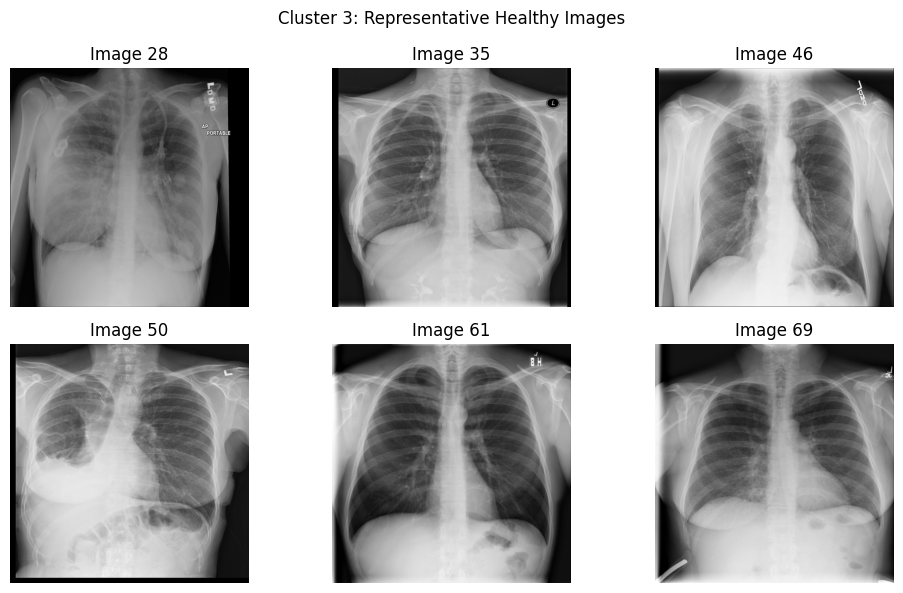

In [45]:
cluster_3_indices = np.where(cluster_labels == 3)[0]
plt.figure(figsize=(10, 6))
plt.suptitle("Cluster 3: Representative Healthy Images")

for i, index in enumerate(cluster_3_indices[:6]):  # Show max 6 images
    ds = dcmread(dicom_files[index])
    plt.subplot(2, 3, i + 1)
    plt.imshow(ds.pixel_array, cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f"Image {index}")

plt.tight_layout()
plt.show()


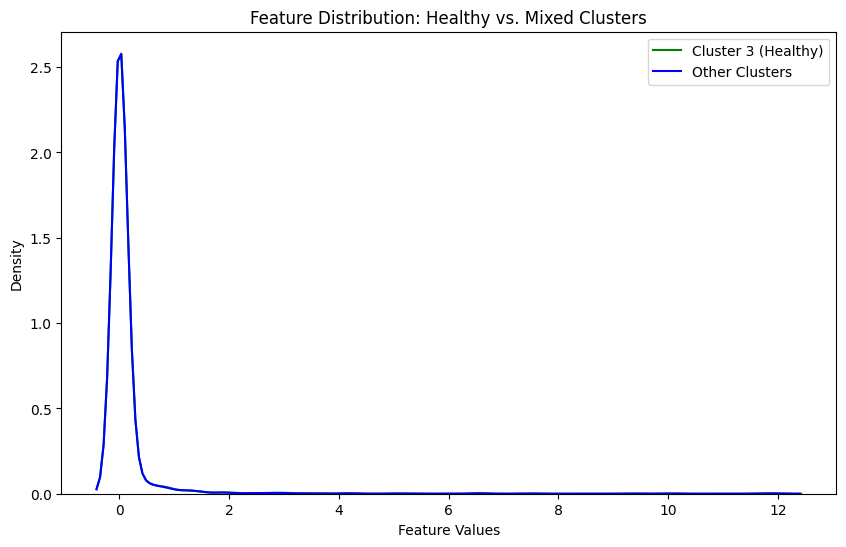

In [46]:
import seaborn as sns

# Extract features for cluster 3 and others
cluster_3_features = features_array[cluster_labels == 3]
other_features = features_array[cluster_labels != 3]

# Visualize mean feature distributions
plt.figure(figsize=(10, 6))
sns.kdeplot(np.mean(cluster_3_features, axis=0), label="Cluster 3 (Healthy)", color="green")
sns.kdeplot(np.mean(other_features, axis=0), label="Other Clusters", color="blue")
plt.title("Feature Distribution: Healthy vs. Mixed Clusters")
plt.xlabel("Feature Values")
plt.legend()
plt.show()


In [47]:
# Create binary labels
# Healthy images in cluster 3 are labeled as 0, all others as 1
binary_labels = (cluster_labels != 3).astype(int)  # 0 for healthy (Cluster 3), 1 for others


In [48]:
from sklearn.model_selection import train_test_split

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(features_array, binary_labels, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")


Training set size: 638, Testing set size: 160


In [49]:
from sklearn.linear_model import LogisticRegression

# Initialize the logistic regression model
log_reg = LogisticRegression(class_weight={0: 10, 1: 1}, random_state=42)
log_reg.fit(X_train, y_train)


LogisticRegression(class_weight={0: 10, 1: 1}, random_state=42)

In [50]:
from sklearn.metrics import accuracy_score, classification_report

# Make predictions
y_pred = log_reg.predict(X_test)

# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Healthy", "Pneumothorax/Mixed"]))


Accuracy: 91.25%
Classification Report:
                    precision    recall  f1-score   support

           Healthy       0.52      1.00      0.68        15
Pneumothorax/Mixed       1.00      0.90      0.95       145

          accuracy                           0.91       160
         macro avg       0.76      0.95      0.82       160
      weighted avg       0.95      0.91      0.92       160



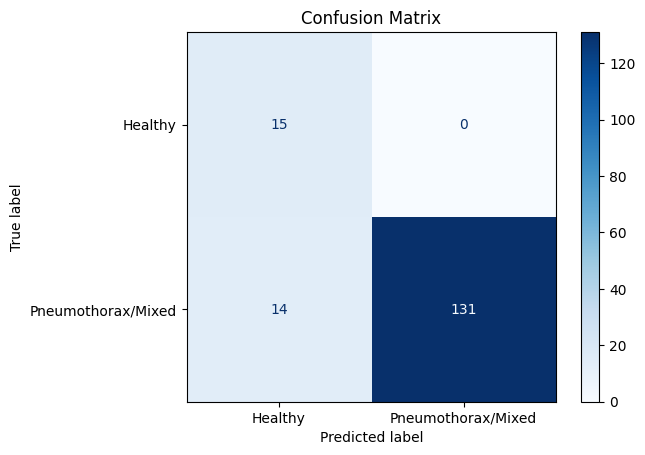

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Pneumothorax/Mixed"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()



## **Feature Distribution Analysis**

A KDE plot was used to compare the feature distributions between cluster 3 (healthy) and the other clusters (mixed):

- **Cluster 3** (Healthy) had a distinct feature distribution compared to the other clusters.


---

## **Logistic Regression Model for Classification**

- **Model Creation**: A logistic regression model was trained to classify images into healthy or pneumothorax/mixed categories.
- **Binary Labels**: Healthy images in cluster 3 were labeled as 0, and all other images were labeled as 1.
- **Data Splitting**: The dataset was split into 80% training and 20% testing.

**Training and Testing Set Sizes:**
- **Training set**: 80%
- **Testing set**: 20%

---

## **Model Evaluation**

- **Accuracy**: The logistic regression model achieved an accuracy of 91.25%.
- **Classification Report**:
